In [6]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.io import fits
from astroquery.sdss import SDSS
from urllib.request import urlopen
import bz2
import io
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import subprocess
from astropy.convolution import convolve, Box2DKernel

matplotlib.rcParams['figure.facecolor'] = 'w'
def setImgSize(width, height): matplotlib.rcParams['figure.figsize'] = [width, height]
def setFontSize(size): matplotlib.rc('font', size=size)


/data/highzgal/adams900/conda/envs/clumpy3.6/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


## Image display

In [3]:
def map_Lupton04(r,g,b,beta=3.,args={}):
    """Lupton et al. (2004) mapping
    DESCRIPTION
      First define radius: rad = beta * (r + g + b).  Then the mapping is
      given by
        R = r*f(rad), G = g*f(rad), B = b*f(rad) ,
      where
               / 0,                     x <= 0 ,
        f(x) = |
               \ arcsinh(x) / x,        x > 0 .
      Hence the mapped values are NOT normalized to [0,1].  Saturation and
      max(R,G,B) > 1 cases have not been taken care of.
    """
    N = np
    # prepare various parameters
    if 'beta' in args: beta = args['beta']
    r,g,b = N.asarray(r).copy(),N.asarray(g).copy(),N.asarray(b).copy()
    # make sure all the entries are >= 0
    r = N.where(r>0., r, 0.)
    g = N.where(g>0., g, 0.)
    b = N.where(b>0., b, 0.)
    # compute nonlinear mapping
    radius = beta * (r + g + b)
    radius_ok = radius > 0.0
    nlfac = radius * 0.0
    nlfac[radius_ok] = N.arcsinh(radius[radius_ok])/radius[radius_ok]
    r = r*nlfac
    g = g*nlfac
    b = b*nlfac
    if args.get('desaturate'):
        # optionally desaturate pixels that are dominated by a single
        # colour to avoid colourful speckled sky
        a = (r+g+b)/3.0
        N.putmask(a, a == 0.0, 1.0)
        rab = r / a / beta
        gab = g / a / beta
        bab = b / a / beta
        mask = N.array((rab, gab, bab))
        w = N.max(mask, 0)
        N.putmask(w, w > 1.0, 1.0)
        w = 1 - w
        w = N.sin(w*N.pi/2.0)
        r = r*w + a*(1-w)
        g = g*w + a*(1-w)
        b = b*w + a*(1-w)
    # optionally add a grey pedestal
#     if args.has_key('pedestal'):
#         pedestal = args['pedestal']
#         r += pedestal
#         g += pedestal
#         b += pedestal
    return r, g, b

# Color balances and Lupton scales I, R, G bands into RGB image
def IRG2RGB(irgFlux):
    colorScale = {'i':8, 'r':8, 'g':8}
    colorBands = {f: irgFlux[f] * colorScale[f] for f in 'irg'}
    r, g, b = map_Lupton04(colorBands['i'], colorBands['r'], colorBands['g'])
    return np.dstack((r, g, b))

# Convenience function to view a black-and-white image of a single band
def band2RGB(bandFlux):
    irgFlux = {f: bandFlux for f in 'irg'}
    return IRG2RGB(irgFlux)

## Requesting an image from SDSS

In [4]:
def requestPhotoObj(specObjId, bands='zirgu'):
    bands = bands.lower()
    fields = [
        'p.specobjid',
        'p.objid',
        'p.ra',
        'p.dec', 
        'p.run',
        'p.rerun',
        'p.camcol',
        'p.field',
        's.z'
    ]
    fieldsStr = ', '.join(fields)
    
    photoTable = 'PhotoPrimary'
    query = ("SELECT {}"
             " FROM {} AS p"
             " JOIN SpecPhoto AS s "
             " ON s.specobjid=p.specobjid"
             " WHERE p.specobjid = {}".format(fieldsStr, photoTable, specObjId)
            )
    
    result = SDSS.query_sql(query)
    if result is None: return None
    resultDict = {cn: result[cn][0] for cn in result.colnames}
    return resultDict

def zeroPad(s, numDigits):
    ss = str(s)
    return "0"*(numDigits-len(ss))+ss

def getFitsUrl(photoObjDict, filterBand):
    run = photoObjDict['run']
    rerun = photoObjDict['rerun']
    camcol = photoObjDict['camcol']
    field = photoObjDict['field']
    field4 = zeroPad(field, 4)
    run6 = zeroPad(run, 6)
    return "http://dr12.sdss.org/sas/dr12/boss/photoObj/frames/{RERUN}/{RUN}/{CAMCOL}/frame-{FILTER}-{RUN6}-{CAMCOL}-{FIELD}.fits.bz2".format(
        RERUN=rerun, RUN=run, CAMCOL=camcol, FIELD=field4, RUN6=run6, FILTER=filterBand
    )

# Gets the actual FITS file in a given band
# You can just plug in the dict returned by "requestPhotoObj"
def requestFitsFile(photoObjDict, filterBand):
    filterBand = filterBand.lower()
    fitsUrl = getFitsUrl(photoObjDict, filterBand)
    try:
        response = urlopen(fitsUrl)
    except Exception as e:
        # If anything goes wrong while requesting, return None and continue
        print("Could not retrieve FITS file.")
        print("photoObjDict:", photoObjDict)
        print("Exception:", e)
        return None
    fileZipped = response.read()
    fileBytes = bz2.decompress(fileZipped)
    file = io.BytesIO(fileBytes)
    fitsFile = fits.open(file)
    return fitsFile

# Returns a dict with fits files in the requested bands
def requestFitsFiles(photoObjDict, bands='zirgu'):
    return {f: requestFitsFile(photoObjDict, f) for f in bands}

def getHDUs(fitsBands):
    return {f: fitsBands[f][0] for f in fitsBands}

def trimFits(hdu, xMin, xMax, yMin, yMax):
    hdu.header['CRPIX2'] -= xMin
    hdu.header['CRPIX1'] -= yMin
    hdu.header['NAXIS2'] = xMax - xMin
    hdu.header['NAXIS1'] = yMax - yMin
    hdu.data = hdu.data[yMin:yMax, xMin:xMax]
    return hdu

def makeCutout(hdu, ctrRaDec, sideLen):
    wcs = WCS(hdu.header)
    ctrX, ctrY = wcs.wcs_world2pix([ctrRaDec], 0).astype('int')[0] # Casting to int rounds it
    pm = int(sideLen/2)
    xMin, xMax = ctrX-pm, ctrX+pm
    yMin, yMax = ctrY-pm, ctrY+pm
    return trimFits(hdu, xMin, xMax, yMin, yMax)

## EXAMPLE REQUEST BELOW!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


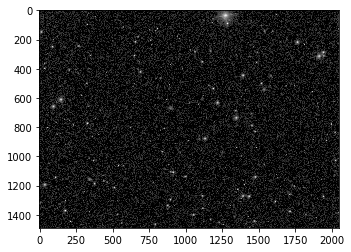

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


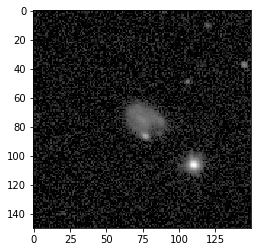

In [10]:
exampleSpecObjId = 1109090338984716288

# Get the info on the source 
srcInfo = requestPhotoObj(exampleSpecObjId)
fitsFiles = requestFitsFiles(srcInfo)

ctrRaDec = srcInfo['ra'], srcInfo['dec']

# The whole field
fieldForDisplay = band2RGB(fitsFiles['r'][0].data)
plt.imshow(fieldForDisplay)
plt.show()

# Make the cutout
sideLength = 150 # Pixels
rCutout = makeCutout(fitsFiles['r'][0], ctrRaDec, sideLength)

# The cutout
cutoutForDisplay = band2RGB(rCutout.data)
plt.imshow(cutoutForDisplay)
plt.show()

In [134]:
# Take a ride on the SExtractor

def getFilename(galId): return 'galaxy_cutouts_big/{}.fits'.format(galId)

def callSextractorAndLoadOutput(inputFilepath, configFilepath='sextractor_config/config.sex'):
    cmd = ['./sex_v2.5',
           inputFilepath,
           '-c',
           configFilepath]
    subprocess.call(cmd)
    return inputFilepath

In [107]:

def smoothImage(hdu, convSize):
    hduSmoothed = hdu.copy()
    hduSmoothed.data = convolve(hduSmoothed.data, Box2DKernel(convSize))
    return hduSmoothed


In [116]:
galIndices = np.random.choice(len(catSDSS), numgals)

Exception: Empty or corrupt FITS file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


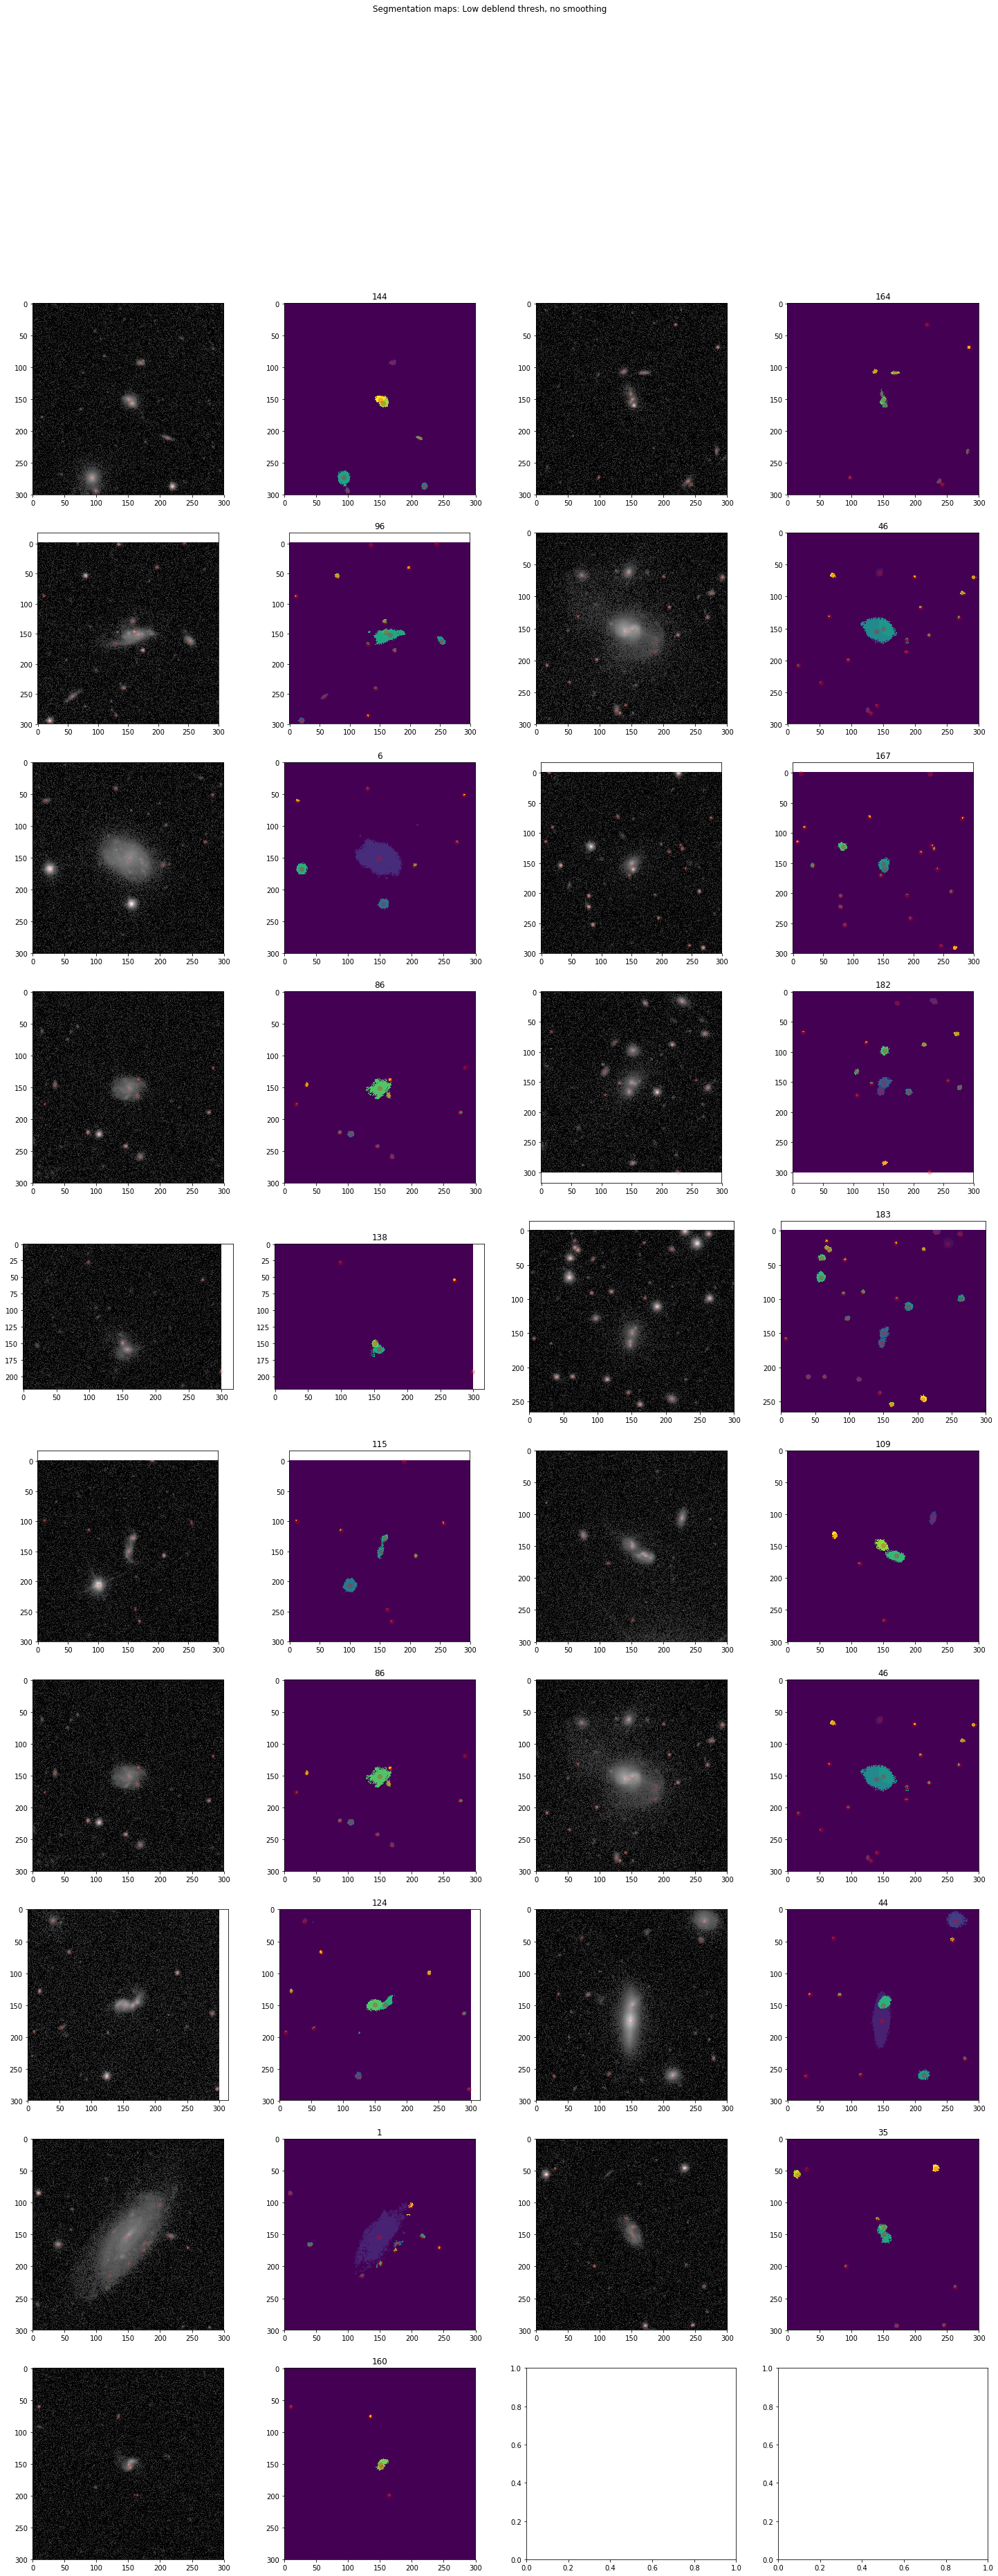

In [137]:
setImgSize(25,60)

numgals = 20
f, axes = plt.subplots(int(numgals/2), 4)
axes = axes.flatten()

axIndex = 0

convSize = 1
for index in galIndices:
    try:
        galId = catSDSS['galaxy_id'][index]
        imgFile = getFilename(galId)
        hdu = fits.open(imgFile)[0]

         # Smoothes the original image
        hduSmoothed = smoothImage(hdu, convSize)

        # Segments the image with SExtractor
        inputFilepath = './sextractor_out/sextractor_in.fits'
        hduSmoothed.writeto(inputFilepath, overwrite=True)
        
        fitsSegmented = callSextractorAndLoadOutput(inputFilepath)
        catFile = fits.open('sextractor_out/output.cat')
        catTable = Table(catFile[1].data)

        imgData = fits.open(imgFile)[0].data
        segData = fits.open('sextractor_out/segmented.fits')[0].data

        ax = axes[axIndex]
        ax.imshow(band2RGB(imgData))
        ax.scatter(catTable['X_IMAGE']-1, catTable['Y_IMAGE']-1, marker='o', alpha=0.1, color='red')
        ax = axes[axIndex+1]
        ax.imshow(segData)
        ax.scatter(catTable['X_IMAGE']-1, catTable['Y_IMAGE']-1, marker='o', alpha=0.25, color='red')
        ax.set_title(index)
        
        axIndex += 2
    except Exception as e:
        print('Exception:', e)

plt.suptitle('Segmentation maps: Low deblend thresh, no smoothing')
plt.show()

In [75]:
for index in range(10):
    galId = catSDSS['galaxy_id'][index]
    callSextractorAndLoadOutput(getFilename(galId))
    f = fits.open('sextractor_out/output.cat')
    t = Table(f[1].data)
    
    imgCenter = 

matplotlib.patches.Circle

In [139]:

catSDSS[6]

specObjID,class,subClass,z,ra,dec,plate,fiberID,MJD,OII3726,OIII4959,OIII5007,HBeta,HAlpha,NII6584,logM,galaxy_id,file_created
int64,str6,str13,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,bool
440364882181777408,GALAXY,STARFORMING,0.01384861,7.4099163,0.41037371,391,502,51782,0.0,31.35988,99.56178,83.55561,262.4785,54.75702,9.59479706440307,782668678393,True
